In [1]:
import pandas as pd
import numpy as np
import re
import torch
from transformers import AutoModel, AutoTokenizer
from torch.optim import Adam
from tqdm import tqdm
import os
from pandas.tseries.offsets import MonthEnd
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import r2_score

/root/miniconda3/envs/myconda/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Read data in 
data = pd.read_csv('AMZN.csv')[['title','return']]
data['title'] = data['title'].astype(str)

In [3]:
# import LLMs and set the dataset
model_name = 'bert-base-uncased'
# tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
class Dataset(torch.utils.data.Dataset):
    def __init__(self,data_trail ):
        self.labels = [data_trail['return'].iloc[i] for i in range(len(data_trail))]
        self.texts = [tokenizer(data_trail['title'].iloc[i], 
                                padding='max_length', 
                                max_length = 64, 
                                truncation=True,
                                return_tensors="pt") 
                      for i in range(len(data_trail))]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):
        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)
        return batch_texts, batch_y

In [4]:
#split the data into train,val, test
df_train, df_val, df_test = np.split(data.sample(frac=1, random_state=42), 
                                     [int(.6*len(data)), int(.8*len(data))])

print(len(df_train),len(df_val), len(df_test))

34669 11557 11557


In [5]:
#model building 
from torch import nn
from transformers import BertModel

class BertModel(nn.Module):
    def __init__(self,drop = 0.2):
        super(BertModel, self).__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(p=drop)
        self.linear = nn.Linear(768, 1)

    def forward(self, input_id, mask):
        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        pooled_output = self.dropout(pooled_output)
        linear_output = self.linear(pooled_output)
        return linear_output 

In [13]:

train_data = df_train
val_data = df_val
# Set epochs
epochs = 1
#set the hypepara drop out rate
model = BertModel(drop = 0.99)
#set the learning rate
learning_rate = 1e-6
#set the ridge hypepara
l2 = 1e-5


corr_mean = []

for time in range(1):
    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=64, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=200)
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    #used the MSE loss
    criterion = nn.MSELoss()
    #input the learning rate and the ridge parameter. 
    optimizer = Adam(model.parameters(), lr=learning_rate,weight_decay=l2)
    if use_cuda:
        model = model.cuda()
        criterion = criterion.cuda()
    total_loss = []
    total_cor= []
    for epoch_num in range(epochs):
            output_total = []
            valput_total = []

            # total_loss_train = 0


            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)

                output = output.flatten()
                train_label = train_label.double()
                output = output.double()

                batch_loss = criterion(output, train_label)
                # total_loss_train += batch_loss.item()

                total_loss.append(batch_loss.item())

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            # total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)
                    output = output.flatten()

                    val_label = val_label.double()
                    output = output.double()
                    batch_loss = criterion(output, val_label)
                    output_total.append(output.cpu())
                    valput_total.append(val_label.cpu())
                    corration = torch.corrcoef(torch.tensor([output.cpu().numpy(),val_label.cpu().numpy()]))[0][1].tolist()
                    total_cor.append(corration)
                    label = f'''Epochs: {epoch_num + 1} || Corr: {corration: .6f}'''
    #                 plt.scatter(output.cpu().numpy(),val_label.cpu().numpy(),label = label)
    #                 plt.legend()
    #                 plt.savefig(label+'.jpg')
    #                 plt.show()
                output_total = list(map(lambda x:x.tolist(),output_total))
                valput_total = list(map(lambda x:x.tolist(),valput_total))
                rvalput = []
                routput = []
                for i in valput_total:
                    rvalput+= i
                for i in output_total:
                    routput += i 
                label = np.corrcoef(rvalput,routput)


            print(label[0][1])  
            corr_mean.append(label[0][1])


100%|██████████| 542/542 [02:23<00:00,  3.78it/s]


0.014889574321823518


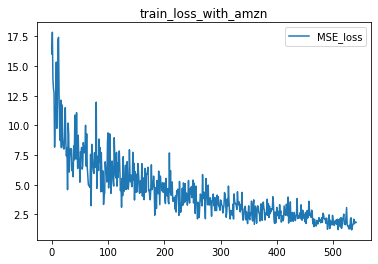

In [15]:
import matplotlib.pyplot as plt 
plt.plot([i for i in range(len(total_loss))],total_loss,label = 'MSE_loss')
plt.legend()
plt.title('train_loss_with_amzn')
plt.show()

#### 